In [6]:
import os
import pickle
import numpy as np
import pandas as pd
import shapely
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt

In [7]:
eog_tiles = gpd.GeoDataFrame(
    geometry = [
        shapely.box(-180, 0, -60, 75),
        shapely.box(-60, 0, 60, 75),
        shapely.box(60, 0, 180, 75),
        shapely.box(-180, -75, -60, 0),
        shapely.box(-60, -75, 60, 0),
        shapely.box(60, -75, 180, 0)
    ],
    crs = 4326
)

In [3]:
# import shoreline
if not os.path.exists("Q:/HEALECON/Felix/Research/Heat Islands/data/shoreline.pkl"):
    shoreline = gpd.read_file("Q:/HEALECON/Felix/Research/Heat Islands/data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp", engine = "pyogrio")
    shoreline = shoreline.unary_union
    pickle.dump(shoreline, open("Q:/HEALECON/Felix/Research/Heat Islands/data/shoreline.pkl", "wb"))
else:
    shoreline = pickle.load(open("Q:/HEALECON/Felix/Research/Heat Islands/data/shoreline.pkl", "rb"))

In [ ]:
### RAMA

# please download annual night lights data from https://eogdata.mines.edu/nighttime_light/annual/v21/
# write a script to get all "median_masked" files and organize them in a adequate, clean folder structure
# mask out the shoreline (see below) (think about making all file paths in this notebook relative)
# assemble them into a single xarray/dask out-of-memory dataset that you export to .zarr

# some of this might be infeasible or impossible. In that case please let me know
# we might also use monthly data further down the road, but for now annual is fine

In [3]:
# import tile
tile = rxr.open_rasterio("Q:/HEALECON/Felix/Research/Heat Islands/data/SVDNB_npp_20120401-20120430_00N060E_vcmcfg_v10_c201605121456.avg_rade9h.tif")
# import cloud free count
tile_cf = rxr.open_rasterio("Q:/HEALECON/Felix/Research/Heat Islands/data/SVDNB_npp_20120401-20120430_00N060E_vcmcfg_v10_c201605121456.cf_cvg.tif")
# mask out no data
tile = tile.where(tile_cf != 0, np.nan)

In [144]:
# mask out water
tile = tile.rio.clip([shoreline])

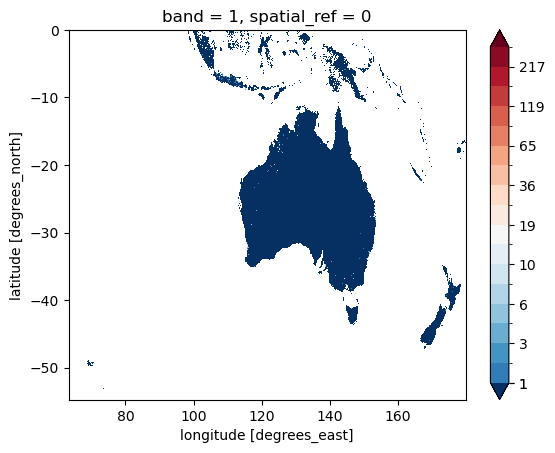

In [149]:
fig, ax = plt.subplots()
tile.squeeze().plot.imshow(ax = ax, levels = np.geomspace(1, test_subset.max(), num=20, dtype=int))

In [ ]:
# Save as Zarr
tile.to_zarr("Q:/HEALECON/Felix/Research/Heat Islands/data/test_processed.zarr", mode="w", consolidated=True)

---

In [106]:
test_boundary = gpd.read_file("Q:/HEALECON/Felix/Research/Heat Islands/data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp", engine="pyogrio").query("ADMIN=='Papua New Guinea'")

test_boundary.bounds.iloc[0]

minx    140.849211
miny    -11.636326
maxx    155.967540
maxy     -1.346368
Name: 160, dtype: float64

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

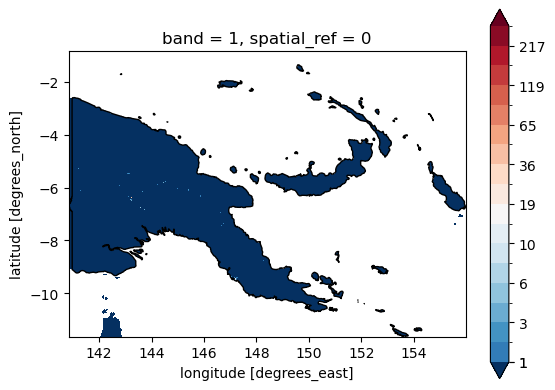

In [130]:
test_subset = test.rio.clip_box(*test_boundary.bounds.iloc[0])

fig, ax = plt.subplots()

test_subset.rio.clip([shoreline]).squeeze().plot.imshow(ax = ax, levels = np.geomspace(1, test_subset.max(), num=20, dtype=int))
test_boundary.plot(ax=ax, color = "none")

---

In [4]:
# load landsat wrs2 grid
landsat_wrs2 = gpd.read_file("Q:/HEALECON/Felix/Research/Heat Islands/data/WRS2_descending_0/WRS2_descending.shp", engine="pyogrio")

# filter out those not covering land
if not os.path.exists("Q:/HEALECON/Felix/Research/Heat Islands/data/any_land.pkl"):
    any_land = np.vstack([landsat_wrs2.intersects(list(shoreline.geoms)[i]) for i in range(len(shoreline.geoms))]).any(axis = 0)
    pickle.dump(any_land, open("Q:/HEALECON/Felix/Research/Heat Islands/data/any_land.pkl", "wb"))
else:
    any_land = pickle.load(open("Q:/HEALECON/Felix/Research/Heat Islands/data/any_land.pkl", "rb"))
landsat_wrs2_land = landsat_wrs2.loc[any_land,:]

<Axes: >

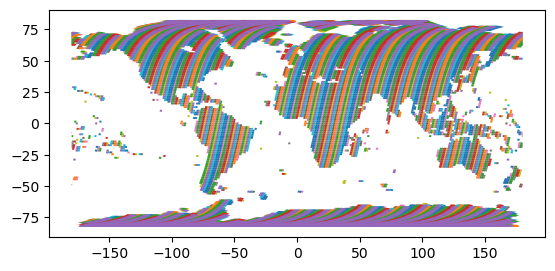

In [24]:
landsat_wrs2_land.plot(column = "ACQDayL7")

---

In [154]:
import os
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import ee

def authenticate():
    # import code_verifier and authorization_code from misc/ee_auth.txt
    with open("Q:/HEALECON/Felix/Research/Heat Islands/misc/ee_auth.txt", "r") as f:
        code_verifier, authorization_code = f.read().split("\n")

    # Trigger the authentication flow.
    ee.Authenticate()# code_verifier=code_verifier, authorization_code = authorization_code
    # Initialize the Earth Engine module
    ee.Initialize(project = "ee-growthandheat")

# Function to calculate a cloud score for a Landsat image
def cloud_score(image):
    blue = image.select('SR_B2')  # Blue band
    green = image.select('SR_B3')  # Green band
    red = image.select('SR_B4')  # Red band
    nir = image.select('SR_B5')  # Near-Infrared band
    swir1 = image.select('ST_B6')  # Shortwave Infrared 1 (Corrected band name)
    swir2 = image.select('SR_B7')  # Shortwave Infrared 2

    # Compute normalized differences
    ndsi = image.normalizedDifference(['SR_B3', 'ST_B6'])  # Snow Index
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4'])  # Vegetation Index

    # Brightness computation
    brightness = (blue.add(green).add(red).add(nir).add(swir1).add(swir2)).divide(6)

    # Cloud likelihood based on brightness and indices
    cloud_score = brightness.subtract(ndvi).add(ndsi).rename('cloud_score')

    # Normalize cloud score to [0,1] range
    cloud_score = cloud_score.divide(65535)

    return image.addBands(cloud_score)

# Function to apply cloud masking
def apply_cloud_mask(image):
    cloud_mask = image.select('cloud_score').lte(0.4)  # Keep only cloud-free pixels
    return image.updateMask(cloud_mask)

def query_temperature_year(tiles, year, cloud_name_prefix = None):
    # build ee filter object
    nepal_filter = ee.Filter.Or([ee.Filter.And(ee.Filter.eq('WRS_PATH', int(path)), ee.Filter.eq('WRS_ROW', int(row))) for path, row in tiles])
    # Load the Landsat 7 image collection
    collection = (ee.ImageCollection('LANDSAT/LE07/C02/T1_L2')
        .filter(nepal_filter)
        .filter(ee.Filter.lessThanOrEquals("CLOUD_COVER", 40))
        #.filter(ee.Filter.And(ee.Filter.eq('WRS_PATH', 175), ee.Filter.eq('WRS_ROW', 83)))
        .filterDate(f'{year}-01-01', f'{year}-12-31'))

    # check if the collection is not empty
    if collection.size().getInfo() == 0:
        raise ValueError("No images in queried collection")

    # Apply cloud mask to the collection
    cloud_free_collection = collection.map(cloud_score).map(apply_cloud_mask)
    # TODO : Implement FMASK cloud masking?
    # https://developers.google.com/earth-engine/apidocs/ee-algorithms-fmask-matchclouds
    
    # Compute the median using ee.Reducer.mean
    median = cloud_free_collection.select("ST_B6").reduce(ee.Reducer.mean())
    
    # Export
    export_task = ee.batch.Export.image.toCloudStorage(
        image=median.uint16(),
        description=f"{cloud_name_prefix}_{year}",
        bucket="growthandheat",
        region=cloud_free_collection.geometry().transform("EPSG:4326"),
        crs="EPSG:4326",
        crsTransform=[0.0041666667, 0.0, 59.99791666665, 0.0, -0.0041666667, 0.00208333335],
        scale=500
    )
    export_task.start()
    
    return export_task

In [2]:
# load landsat wrs2 grid
landsat_wrs2 = gpd.read_file("Q:/HEALECON/Felix/Research/Heat Islands/data/WRS2_descending_0/WRS2_descending.shp", engine="pyogrio")

# filter out those not covering land
if not os.path.exists("Q:/HEALECON/Felix/Research/Heat Islands/data/any_land.pkl"):
    any_land = np.vstack([landsat_wrs2.intersects(list(shoreline.geoms)[i]) for i in range(len(shoreline.geoms))]).any(axis = 0)
    pickle.dump(any_land, open("Q:/HEALECON/Felix/Research/Heat Islands/data/any_land.pkl", "wb"))
else:
    any_land = pickle.load(open("Q:/HEALECON/Felix/Research/Heat Islands/data/any_land.pkl", "rb"))
landsat_wrs2_land = landsat_wrs2.loc[any_land,:]

In [3]:
# load the boundaries of Nepal
nepal = gpd.read_file("Q:/HEALECON/Felix/Research/Heat Islands/data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp", engine="pyogrio").query("ADMIN=='Nepal'")
# filter grid tiles covering Nepal
nepal_tiles = landsat_wrs2_land.loc[landsat_wrs2_land.intersects(nepal.unary_union),:][["PATH", "ROW"]].values

<Axes: >

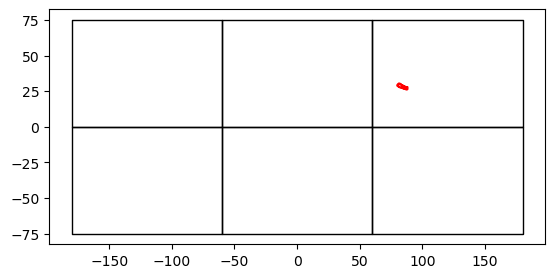

In [9]:
ax = eog_tiles.plot(color = "none")
nepal.boundary.plot(ax=ax, color = "red")

In [155]:
authenticate()

for year in range(2013, 2023):
    query_temperature_year(nepal_tiles, year, cloud_name_prefix = "nepal_cloud_free_st")

In [13]:
# # Reproject
# projected = median.reproject(
#     crs='EPSG:4326',
#     crsTransform=[0.0041666667, 0.0, 59.99791666665, 0.0, -0.0041666667, 0.00208333335]
# )

# # Transform into meaningful scale (based on USGS Landsat 7 ETM+ Collection 2 Level 2 Data Format Control Book, Table 3.2)
# viewable = projected.multiply(0.00341802).add(149.0)

# # Display the result
# import geemap
# Map = geemap.Map()
# Map.centerObject(viewable, 9)
# st_params = {"min": 223.15, "max": 323.15, "palette": ['blue', 'white', 'green']}
# Map.addLayer(viewable, st_params, "ST image")
# Map

Map(center=[28.072510421089458, 83.88344505801915], controls=(WidgetControl(options=['position', 'transparent_…

---

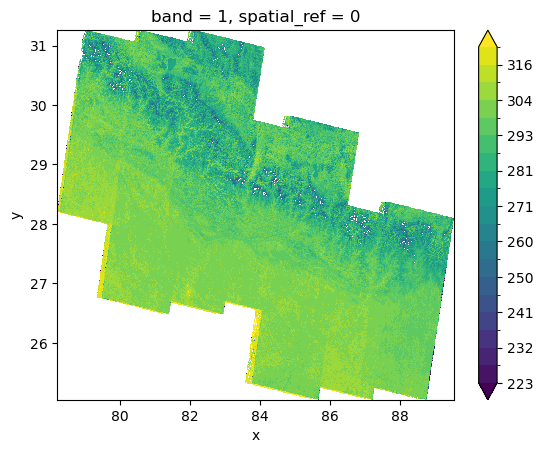

In [12]:
import xarray as xr
import rioxarray as rxr
from matplotlib import pyplot as plt

nepal_cloud_data = rxr.open_rasterio("Q:/HEALECON/Felix/Research/Heat Islands/data/nepal_cloud_free_st_2012.tif")
# plot in Kelvin
fig, ax = plt.subplots()
(nepal_cloud_data.where(nepal_cloud_data > 0, np.nan) * 0.00341802 + 149).squeeze().plot.imshow(ax = ax, levels = np.geomspace(223.15, 323.15, num=20, dtype=int))

---

In [1]:
import os
import pickle
import xarray as xr
import rioxarray as rxr
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt

In [2]:
# load landsat wrs2 grid
landsat_wrs2 = gpd.read_file("Q:/HEALECON/Felix/Research/Heat Islands/data/WRS2_descending_0/WRS2_descending.shp", engine="pyogrio")

# filter out those not covering land
if not os.path.exists("Q:/HEALECON/Felix/Research/Heat Islands/data/any_land.pkl"):
    any_land = np.vstack([landsat_wrs2.intersects(list(shoreline.geoms)[i]) for i in range(len(shoreline.geoms))]).any(axis = 0)
    pickle.dump(any_land, open("Q:/HEALECON/Felix/Research/Heat Islands/data/any_land.pkl", "wb"))
else:
    any_land = pickle.load(open("Q:/HEALECON/Felix/Research/Heat Islands/data/any_land.pkl", "rb"))
landsat_wrs2_land = landsat_wrs2.loc[any_land,:]

In [3]:
# load the boundaries of Nepal
nepal = gpd.read_file("Q:/HEALECON/Felix/Research/Heat Islands/data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp", engine="pyogrio").query("ADMIN=='Nepal'")
# filter grid tiles covering Nepal
nepal_tiles = landsat_wrs2_land.loc[landsat_wrs2_land.intersects(nepal.unary_union),:][["PATH", "ROW"]].values

In [68]:
if not os.path.exists("Q:/HEALECON/Felix/Research/Heat Islands/data/case_studies/nepal/nepal_night_lights.zarr"):
    nepal_night_lights = []
    for year in range(2014, 2022):
        # open file
        night_lights = rxr.open_rasterio(f"/vsigzip/Q:/HEALECON/Felix/Research/Heat Islands/data/night_lights/VNL_v21_npp_{year}_global_vcmslcfg_c202205302300.median_masked.dat.tif.gz")
        # clip to Nepal
        nepal_night_lights += [night_lights.rio.clip_box(*nepal.total_bounds)]
    # merge
    nepal_night_lights_combined = xr.concat(nepal_night_lights, dim = "year", join="override").assign_coords(year = range(2014, 2022)).to_dataset(name = "night_lights")
    # save
    nepal_night_lights_combined.to_zarr("Q:/HEALECON/Felix/Research/Heat Islands/data/case_studies/nepal/nepal_night_lights.zarr", mode="w", consolidated=True)
else:
    nepal_night_lights_combined = xr.open_zarr("Q:/HEALECON/Felix/Research/Heat Islands/data/case_studies/nepal/nepal_night_lights.zarr", decode_coords="all")

In [64]:
if not os.path.exists("Q:/HEALECON/Felix/Research/Heat Islands/data/case_studies/nepal/nepal_ground_temperature.zarr"):
    nepal_ground_temperature = []
    for year in range(2014, 2022):
        # open file
        ground_temperature = rxr.open_rasterio(f"Q:/HEALECON/Felix/Research/Heat Islands/data/case_studies/nepal/raw/nepal_cloud_free_st_{year}.tif")
        # clip to Nepal
        nepal_ground_temperature += [ground_temperature.rio.clip_box(*nepal.total_bounds)]
    # merge
    nepal_ground_temperature_combined = xr.concat(nepal_ground_temperature, dim="year", join ="override").assign_coords(year=range(2014, 2022)).to_dataset(name = "ground_temperature")
    # save
    nepal_ground_temperature_combined.to_zarr("Q:/HEALECON/Felix/Research/Heat Islands/data/case_studies/nepal/nepal_ground_temperature.zarr", mode="w", consolidated=True)
else:
    nepal_ground_temperature_combined = xr.open_zarr("Q:/HEALECON/Felix/Research/Heat Islands/data/case_studies/nepal/nepal_ground_temperature.zarr", decode_coords="all")

In [62]:
# import fiona
# fiona.listlayers("/vsizip/Q:/HEALECON/Felix/Research/Heat Islands/data/gadm_410-levels.zip")
# # ['ADM_0', 'ADM_1', 'ADM_2', 'ADM_3', 'ADM_4', 'ADM_5']

['ADM_0', 'ADM_1', 'ADM_2', 'ADM_3', 'ADM_4', 'ADM_5']

In [100]:
if not os.path.exists("Q:/HEALECON/Felix/Research/Heat Islands/data/case_studies/nepal/adm_2.parquet"):
    nepal_adm_2 = gpd.read_file("/vsizip/Q:/HEALECON/Felix/Research/Heat Islands/data/gadm_410-levels.zip", bbox = tuple(nepal.total_bounds), layer = "ADM_2", engine = "pyogrio")
    nepal_adm_2.to_parquet("Q:/HEALECON/Felix/Research/Heat Islands/data/case_studies/nepal/adm_2.parquet")
else:
    nepal_adm_2 = gpd.read_parquet("Q:/HEALECON/Felix/Research/Heat Islands/data/case_studies/nepal/adm_2.parquet")

In [101]:
from geocube.api.core import make_geocube

# create index column
nepal_adm_2["GID_2_INT"] = nepal_adm_2.index
# create geocube
nepal_adm_2_grid = make_geocube(
    vector_data=nepal_adm_2,
    measurements=["GID_2_INT"],
    like=nepal_ground_temperature_combined.isel(year=0),
    fill=-1,
)

In [132]:
merged = xr.merge(
    [
        nepal_night_lights_combined.squeeze().rio.reproject_match(nepal_ground_temperature_combined), 
        nepal_ground_temperature_combined,
        ],
    join = "inner"
    )

merged = merged.rio.clip(nepal.geometry)

In [22]:
def demean_xarray(da: xr.DataArray) -> xr.DataArray:
    """
    Perform pixel-wise demeaning along the 'year' dimension
    first, then apply year-wise demeaning across all pixels.
    
    Parameters:
    da (xr.DataArray): Input xarray DataArray with a 'year' dimension.
    
    Returns:
    xr.DataArray: Fully demeaned DataArray.
    """
    # Pixel-wise demeaning (demean each pixel across years)
    da_pixel_demeaned = da - da.mean(dim="year", skipna=True)

    # Year-wise demeaning (demean each year across all pixels)
    da_fully_demeaned = da_pixel_demeaned - da_pixel_demeaned.mean(dim=("x", "y"), skipna=True)

    return da_fully_demeaned

In [133]:
demeaned = merged.apply(demean_xarray)

demeaned = xr.merge(
    [
        demeaned,
        nepal_adm_2_grid.rio.reproject_match(nepal_ground_temperature_combined)
    ],
    join = "inner"
)

In [168]:
(merged.ground_temperature.isel(year=7) - merged.ground_temperature.mean(dim = "year")).mean()

<xarray.DataArray 'ground_temperature' ()> Size: 8B
array(-689.19403195)
Coordinates:
    year         int32 4B 2021
    spatial_ref  int32 4B 0

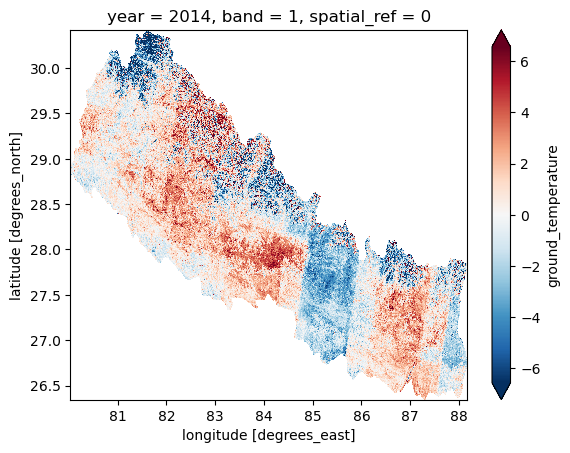

In [177]:
# TODO: get new temperature data without artifacts
# if mean is inadequate, maybe maintain information about mean date and demean based on that
(demeaned.ground_temperature * 0.00341802).isel(year=0).squeeze().plot.imshow(robust = True)

In [178]:
demeaned_long = demeaned.to_dataframe()

In [122]:
demeaned_long.ground_temperature.quantile([0.05, 0.95])

0.05   -1123.862945
0.95    1170.255539
Name: ground_temperature, dtype: float64

In [ ]:
# TODO: include instrument

In [201]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Prepare the data
data = demeaned_long.dropna(subset=['ground_temperature', 'night_lights'])

# Drop outliers outside the 5th and 95th percentiles
data = data.query('ground_temperature > @data.ground_temperature.quantile(0.05) and ground_temperature < @data.ground_temperature.quantile(0.95)')
data = data.query('night_lights > @data.night_lights.quantile(0.05) and night_lights < @data.night_lights.quantile(0.95)')

# Perform the regression
# TODO: Implement log transformations
model = smf.ols('I(ground_temperature * 0.0034180) ~ night_lights', data=data).fit(cov_type='cluster', cov_kwds={'groups': data['GID_2_INT']})

# Print the summary
print(model.summary())

                                    OLS Regression Results                                   
Dep. Variable:     I(ground_temperature * 0.0034180)   R-squared:                       0.001
Model:                                           OLS   Adj. R-squared:                  0.001
Method:                                Least Squares   F-statistic:                     1.452
Date:                               Mi., 19 Feb 2025   Prob (F-statistic):              0.237
Time:                                       18:12:58   Log-Likelihood:            -8.3265e+06
No. Observations:                            4345102   AIC:                         1.665e+07
Df Residuals:                                4345100   BIC:                         1.665e+07
Df Model:                                          1                                         
Covariance Type:                             cluster                                         
                   coef    std err          z      P>|z|    